# **Recopilacion de datos**

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
df_cacao = pd.read_csv('cacao_20240624.csv', header=0)

mapa_columnas = {
    'CÓD. \nDEP.' : 'COD DEPART',
    'CÓD. MUN.':'COD MUN',
    'GRUPO \nDE CULTIVO':'GRUP CULTIVO',
    'SUBGRUPO \nDE CULTIVO':'SUBG CULTIVO',
    'DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO':'SISTEM PRODUCTIVO',
    'Área Sembrada\n(ha)':'AREA SEMBRADA (HA)',
    'Área Cosechada\n(ha)':'AREA COSECHADA (HA)',
    'Producción\n(t)' : 'PRODUCCION (T)',
    'Rendimiento\n(t/ha)':'RENDIMIENTO (T/HA)',
    'ESTADO FISICO PRODUCCION':'EST FISC PRODUCCION',
    'NOMBRE \nCIENTIFICO':'NOM CIENTIFICO',
    'CICLO DE CULTIVO':'CICLO CULTIVO'
}



df_cacao = df_cacao.rename(columns=mapa_columnas)

df_cacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6066 entries, 0 to 6065
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COD DEPART           6066 non-null   int64  
 1   DEPARTAMENTO         6066 non-null   object 
 2   COD MUN              6066 non-null   int64  
 3   MUNICIPIO            6066 non-null   object 
 4   GRUP CULTIVO         6066 non-null   object 
 5   SUBG CULTIVO         6066 non-null   object 
 6   CULTIVO              6066 non-null   object 
 7   SISTEM PRODUCTIVO    6066 non-null   object 
 8   AÑO                  6066 non-null   int64  
 9   PERIODO              6066 non-null   int64  
 10  AREA SEMBRADA (HA)   6066 non-null   int64  
 11  AREA COSECHADA (HA)  6066 non-null   int64  
 12  PRODUCCION (T)       6066 non-null   int64  
 13  RENDIMIENTO (T/HA)   5731 non-null   float64
 14  EST FISC PRODUCCION  6066 non-null   object 
 15  NOM CIENTIFICO       6066 non-null   o

In [65]:
df_departamento = df_cacao[df_cacao['DEPARTAMENTO'] == 'SANTANDER']

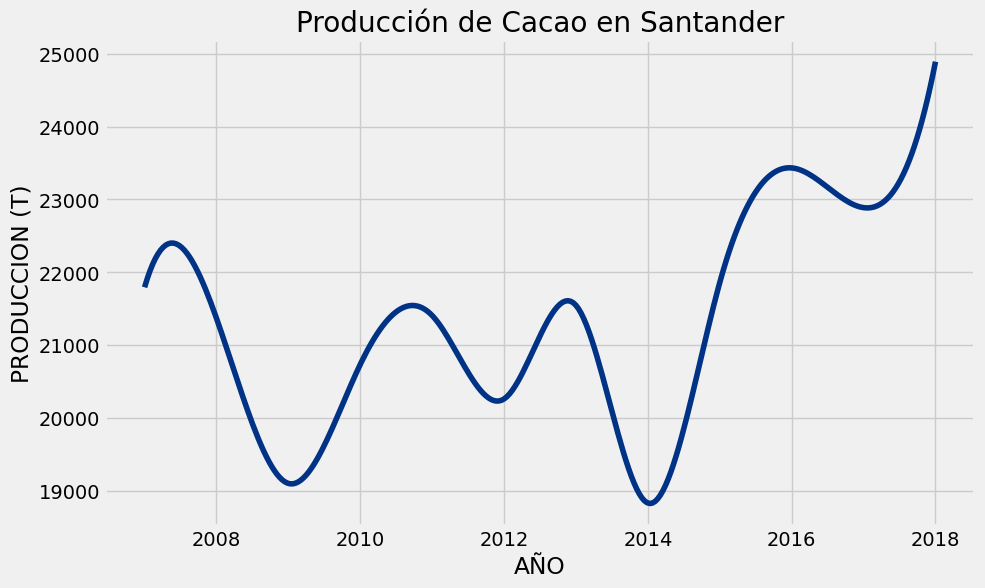

In [66]:
from scipy.interpolate import make_interp_spline
import numpy as np

df_periocidad = df_departamento.groupby('AÑO')['PRODUCCION (T)'].sum().reset_index()

x = df_periocidad['AÑO']
y = df_periocidad['PRODUCCION (T)']

# Crear una nueva serie de puntos suavizados para una línea más redonda
x_smooth = np.linspace(x.min(), x.max(), 300)
spl = make_interp_spline(x, y, k=3)  # k=3 para una suavidad cúbica
y_smooth = spl(x_smooth)


plt.style.use('fivethirtyeight')

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, linestyle='-', color='#003285')  # Línea suave

plt.xlabel('AÑO')
plt.ylabel('PRODUCCION (T)')
plt.title('Producción de Cacao en Santander')
plt.grid(True)
plt.show()

## **Eliminando valores duplicados**

In [67]:
df_departamento = df_departamento.drop(['PERIODO','SUBG CULTIVO','SISTEM PRODUCTIVO', 'RENDIMIENTO (T/HA)'], axis=1)

media = df_departamento['AREA COSECHADA (HA)'].mean()
df_departamento['AREA COSECHADA (HA)'] = df_departamento['AREA COSECHADA (HA)'].replace(0, media)

df_departamento[df_departamento['AREA COSECHADA (HA)'] == 0]

,COD DEPART,DEPARTAMENTO,COD MUN,MUNICIPIO,GRUP CULTIVO,CULTIVO,AÑO,AREA SEMBRADA (HA),AREA COSECHADA (HA),PRODUCCION (T),EST FISC PRODUCCION,NOM CIENTIFICO,CICLO CULTIVO


## **Funciones**

In [68]:
import numpy as np
import unicodedata

def calcular_estadisticas_anuales(df, guardar=False):
    ''' Esta funcion permite limpiar el dataframe que ingresa para poder traer solos los valores que se
        utilizaran, para poder calcular la media y la desviacion para su posterior simulacion '''
    
    #traer las columnas que se desean guardar
    df_limpieza = df[['Fecha','Valor']].copy()

    #convertir la fecha en un tipo de dato fecha
    df_limpieza['Fecha'] = pd.to_datetime(df_limpieza['Fecha'])

    #agrupar por año y calcular la media y la desviacion
    df_limpieza = df_limpieza.groupby(df_limpieza['Fecha'].dt.year)['Valor'].agg(['mean','std']).reset_index()

    #regresamos un df con la media anual y la desv. anual
    return df_limpieza

def calcular_suma_anual(df, guardar=False):
    '''Esta funcion permite sumar valores por dia para convertirlas en valores anuales'''

    df_brillo = df[['Fecha','Valor']].copy()

    #convertir las fechas 
    df_brillo['Fecha'] = pd.to_datetime(df_brillo['Fecha'])
        
    #sumar la cantidad de horas de brillo por año
    df_brillo = df_brillo.groupby(df_brillo['Fecha'].dt.year)['Valor'].sum().reset_index()

    #calcular la cantidad de dias por año
    df_brillo['Días'] = df_brillo['Fecha'].apply(lambda x: 366 if x % 4 == 0 and (x % 100 != 0 or x % 400 == 0) else 365)

    #calcular el promedio de horas solares anual
    df_brillo['Promedio (Horas sol diarias)'] = df_brillo['Valor'] / df_brillo['Días']

    return df_brillo

def generar_numero_aleatorio(row, df):
    #traemos el año de la fila que se esta viendo
    year =  row['AÑO']

    if year in df['Fecha'].values:
        # traemos la media del otro df que corresponde a ese año
        media, desv = df[df['Fecha'] == year][['mean','std']].values[0]


        numero_aleatorio = np.random.normal(loc=media, scale=desv)

        numero_absoluto= np.abs(numero_aleatorio)
        return numero_absoluto
    else:
        return 0

def quitar_tildes(row):
    texto = row['Nombre Centro Poblado']
    
    # Crear una tabla de traducción
    traduccion = str.maketrans(
        "áéíóúÁÉÍÓÚüÜ",
        "aeiouAEIOUuU"
    )
    
    # Aplicar la traducción al texto
    texto_sin_tildes = texto.translate(traduccion)
    
    return texto_sin_tildes


def posicionar_datos_brillo_solar(row, df):
    year = row['AÑO']

    if year in df['Fecha'].values:

        return df[df['Fecha'] == year]['Promedio (Horas sol diarias)'].values[0]
    
def posicionar_datos_geograficos(row, df):
    departamento = row['DEPARTAMENTO']
    municipio = row['MUNICIPIO']
    
    if municipio in df['Nombre Centro Poblado'].unique():
        filtro_df = df[(df['Nombre Departamento'] == departamento) & (df['Nombre Centro Poblado'] == municipio)]

        longitud, latitud = filtro_df[['Longitud','Latitud']].iloc[0]
        
        return longitud, latitud
    else:
        return [np.nan,np.nan]

## **Convertir datos de precipitaciones**

In [69]:
df_precipitaciones = pd.read_csv('datos_precipitacion.csv')

In [70]:
df_precipitaciones_guardar = calcular_estadisticas_anuales(df_precipitaciones)
df_precipitaciones_guardar

,Fecha,mean,std
0,2007,278.266667,156.300906
1,2008,322.491667,191.211922
2,2009,213.675000,107.536963
3,2010,398.100000,207.121528
4,2011,265.866667,135.691604
5,2012,211.233333,145.613575
6,2013,245.216667,136.870143
7,2014,191.100000,114.987027
8,2015,210.550000,124.994585
9,2016,218.583333,144.066530


## **Convertir datos de humedad**

In [71]:
df_humedad = pd.read_csv('datos_humedad.csv')

In [72]:
df_humedad_guardar = calcular_estadisticas_anuales(df_humedad)
df_humedad_guardar.head()

,Fecha,mean,std
0,2007,89.159011,7.135289
1,2011,91.635586,0.698832
2,2012,84.700513,3.066214
3,2013,85.361426,2.317251
4,2014,85.487688,2.347644


## **Convertir datos de temperatura maxima y minima**

In [73]:
df_temperatura_maxima = pd.read_csv('datos_temperatura_maxima.csv')
df_temperatura_minima = pd.read_csv('datos_temperatura_minima.csv')

In [74]:
df_temperatura_maxima_guardar = calcular_estadisticas_anuales(df_temperatura_maxima)
df_temperatura_minima_guardar = calcular_estadisticas_anuales(df_temperatura_minima)

## **Convertir datos de brillo solar**

In [75]:
df_brillo_solar = pd.read_csv('datos_solar_2007_2012.csv')
df_brillo_solar_2 = pd.read_csv('datos_solares_part_2.csv')

In [76]:
df_brillo_solar_parte_1 = calcular_suma_anual(df_brillo_solar)
df_brillo_solar_parte_2 = calcular_suma_anual(df_brillo_solar_2)

df_brillo_solar_concatenado = pd.concat([df_brillo_solar_parte_1, df_brillo_solar_parte_2], ignore_index=True)

In [77]:
df_brillo_solar_concatenado

,Fecha,Valor,Días,Promedio (Horas sol diarias)
0,2007,1874.3,365,5.135068
1,2008,1846.5,366,5.045082
2,2009,2082.3,365,5.704932
3,2010,1746.3,365,4.784384
4,2011,1633.4,365,4.475068
5,2012,1965.6,366,5.370492
6,2013,1909.4,365,5.231233
7,2014,2053.8,365,5.626849
8,2015,2036.0,365,5.578082
9,2016,1498.3,366,4.093716


## **Convertir tildes del df longitud y latitud**


In [78]:
df_geografico = pd.read_excel('Clasificador Geográfico.xlsx')
df_geografico['Nombre Municipio'] = df_geografico.apply(lambda row: quitar_tildes(row), axis=1)

## **Pasar los datos al dataframe de cacao**

In [79]:
#Ingresando los valores simulandos al df

df_departamento_copia = df_departamento.copy()

lista_columnas = ['Precipitaciones (mm)','Humedad (%)', 'Temperatura Maxima (C)', 'Temperatura Minima (C)' ]
lista_df = [df_precipitaciones_guardar, df_humedad_guardar, df_temperatura_maxima_guardar, df_temperatura_minima_guardar]

for nombre,df in zip(lista_columnas, lista_df):
    df_departamento_copia[nombre.upper()] = df_departamento_copia.apply(generar_numero_aleatorio, args=(df,) ,axis=1)


In [80]:
#Ingresando los valores constantes al df

df_departamento_copia['BRILLO SOLAR (Horas sol diarias)'] = df_departamento_copia.apply(posicionar_datos_brillo_solar, args=(df_brillo_solar_concatenado,), axis=1)

In [81]:
#Ingresando los valores de longitud y latitud de un df al df original
df_geografico = pd.read_excel('Clasificador Geográfico.xlsx')

#tratando los datos con tilde
df_geografico['Nombre Centro Poblado'] = df_geografico.apply(lambda row: quitar_tildes(row), axis=1)

#ingresando la latitud y la longitud correspondiennte 
df_departamento_copia['LONGITUD'] = df_departamento_copia.apply(lambda row: posicionar_datos_geograficos(row, df_geografico)[0], axis=1)
df_departamento_copia['LATITUD'] = df_departamento_copia.apply(lambda row: posicionar_datos_geograficos(row, df_geografico)[1], axis=1)


## **Guardando el df a csv**

In [82]:
import os
from pathlib import Path
import psutil 

discos = [d.device for d in psutil.disk_partitions() if 'removable' in d.opts][0]

ruta = Path(f'{discos}Proyecto_monografia/datos_caco_compilado.csv')

#verificar si el archivo ya existe
if os.path.exists(ruta):
    ##Iniciar el contador
    contador = 1
    while True:
        #poner otro nombre al archivo con base al contador
        ruta_nueva = Path(f'{discos}Proyecto_monografia/datos_caco_compilado{contador}.csv')
        
        #verificamos si el archivo en la nueva ruta no existe
        if not os.path.exists(ruta_nueva):
            #si no existe guardamos con el nuevo nombre
            df_departamento_copia.to_csv(ruta_nueva, index=False)
            break
        contador += 1
else:
    df_departamento_copia.to_csv(ruta, index=False)


## **Creacion de un conjunto de prueba**

In [83]:
df_cacao_original = pd.read_csv('datos_caco_compilado.csv')

<Axes: >

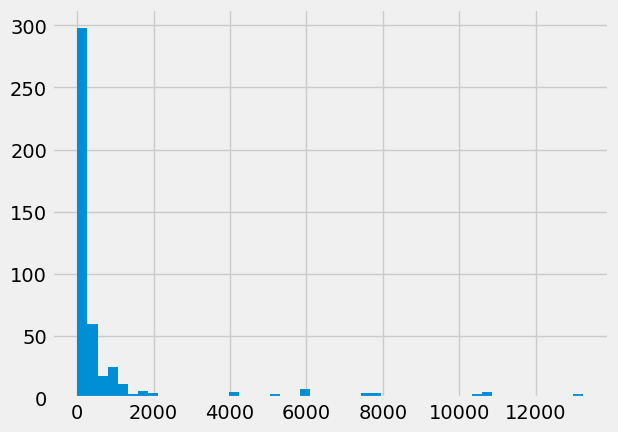

In [84]:
#mirando la distribucion del area cosechada
df_cacao_original['AREA COSECHADA (HA)'].hist(bins=50)

In [85]:
df_cacao_original['ESTRATOS'] = pd.cut(df_cacao_original['AREA COSECHADA (HA)'],
                                       bins=[0., 3000, 6000, 9000,12000,np.inf],
                                       labels=[1,2,3,4,5])

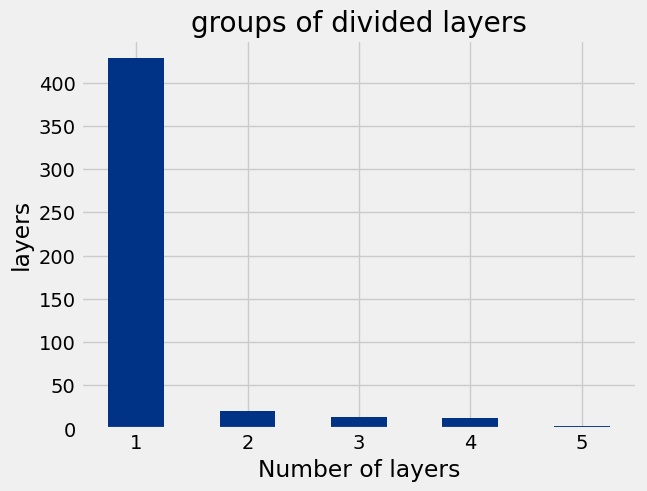

In [86]:
# Visualizando la estratificacion de los datos para el conjunto de prueba representativo
import matplotlib.pyplot as plt

df_cacao_original['ESTRATOS'].value_counts().sort_index().plot.bar(rot=0, color='#003285')
plt.title('groups of divided layers')
plt.xlabel('Number of layers')
plt.ylabel('layers');

In [87]:
from sklearn.model_selection import train_test_split
#Creando el muestreo estratificado
conjunto_entreno, conjunto_prueba = train_test_split(df_cacao_original, test_size=0.2, stratify=df_cacao_original['ESTRATOS'], random_state=42)

#Creando el muestreo aleatorio
conjunto_entreno_aleatorio, conjunto_prueba_aleatorio = train_test_split(df_cacao_original, test_size=0.2, random_state=42)


In [88]:
general = df_cacao_original['ESTRATOS'].value_counts(normalize=True)
estratificado = conjunto_entreno['ESTRATOS'].value_counts(normalize=True)
aleatorio = conjunto_entreno_aleatorio['ESTRATOS'].value_counts(normalize=True)

df_prueba_conjunto_entrenamiento = pd.DataFrame({'General %':general * 100,
                                                 'Estratificado %':estratificado * 100,
                                                 'Aleatorio %':aleatorio * 100,
                                                 'err Estr % ': (general - estratificado)*100,
                                                 'err Alt %': (general - aleatorio)*100}).reset_index()

df_prueba_conjunto_entrenamiento


,ESTRATOS,General %,Estratificado %,Aleatorio %,err Estr %,err Alt %
0,1,89.915966,90.000000,89.473684,-0.084034,0.442282
1,2,4.201681,4.210526,4.210526,-0.008846,-0.008846
2,3,2.731092,2.631579,3.157895,0.099513,-0.426802
3,4,2.521008,2.631579,2.368421,-0.110571,0.152587
4,5,0.630252,0.526316,0.789474,0.103936,-0.159222


In [89]:
from sklearn.model_selection import StratifiedShuffleSplit #importamos la libreria para dividir los datos en prueba y entrenamiento

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42) # como podemos ver esta clase no me permite dividir si no que solo me genera los indices para dividirlos, estos indices basicamente son aleatorios
                                                                               # basicamente el n_splits lo que hace es tomar los valores y cambiarlos por datos de entrenamiento y prueba
strat_splits = [] 

for entrenamiento_index, prueba_index in splitter.split(df_cacao_original, df_cacao_original['ESTRATOS']): # Genera índices de las filas para los conjuntos de entrenamiento y prueba, asegurando que la proporción de categorías en 'estratos' sea la misma en ambos conjuntos. 
                                                                                                           # le pasamos el df que qiueremos dividir, y le pasamos por que area queremos dividir     
                                                                                                                                                                                                                 
    strat_conjunto_entrenamiento = df_cacao_original.iloc[entrenamiento_index] # guardamos en una variable el entrenamiento , la seleccion de los indice que vamos a dejar en el entrenamiento, osea trae una lista con los valores indices y esa lista la pasamos al dataframe y guardamos ese dataframe en una variable
    strat_conjunto_prueba = df_cacao_original.iloc[prueba_index] # igualmente para el conjunto de datos de prueba
    
    
    strat_splits.append([strat_conjunto_entrenamiento, strat_conjunto_prueba]) #guardamos ese conjunto de datos en una lista
    

In [90]:
conjunto_entreno, conjunto_prueba = strat_splits[0]

for set_ in (conjunto_entreno, conjunto_prueba):
    set_.drop("ESTRATOS", axis=1, inplace=True)


C:\Users\ajolo\AppData\Local\Temp\ipykernel_11800\2876989364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("ESTRATOS", axis=1, inplace=True)
C:\Users\ajolo\AppData\Local\Temp\ipykernel_11800\2876989364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("ESTRATOS", axis=1, inplace=True)


## **Explorar y visualizar los datos**

In [91]:
cacao = conjunto_entreno.copy()

### **Matriz de correlación**


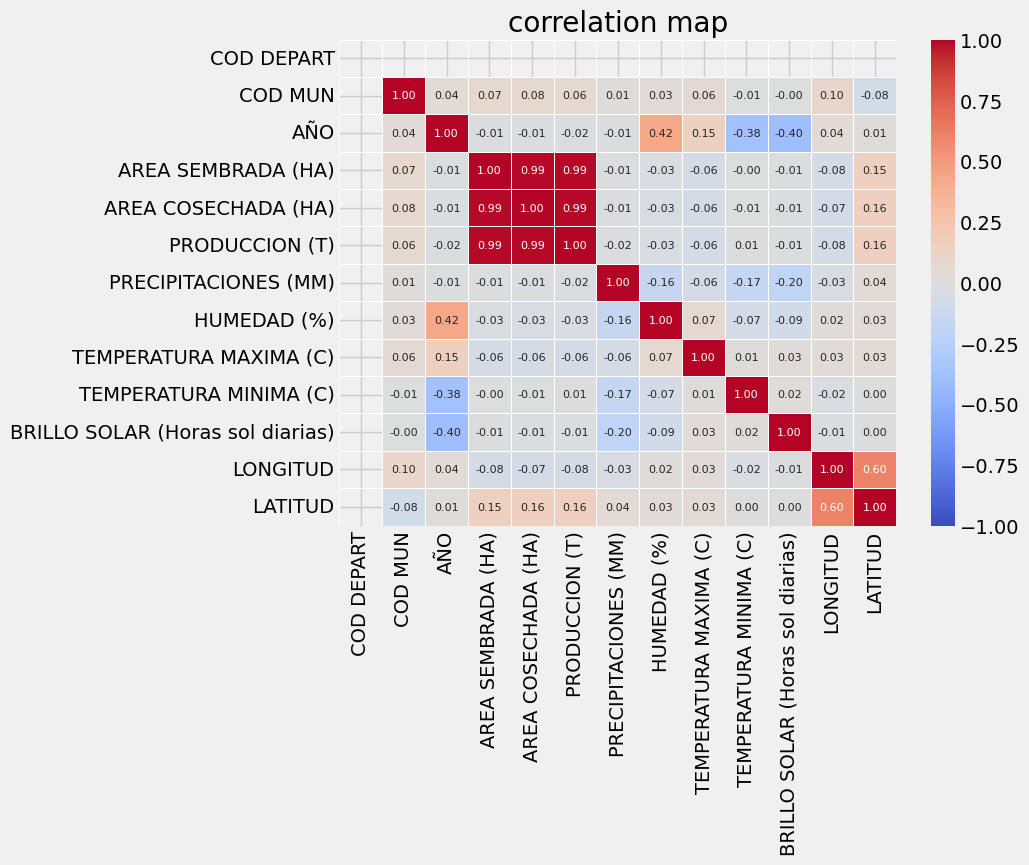

In [92]:
import seaborn as sns
# Calcular la matriz de correlacion
matriz_correlacion = df_cacao_original.select_dtypes(include=['float64','int64']).corr()

#Crear la matriz de la correlacion
plt.figure(figsize=(8,6))
sns.heatmap(
    matriz_correlacion, 
    annot=True,     
    cmap='coolwarm',    
    vmin=-1, 
    vmax=1,    
    center=0,           
    linewidths=0.5,   
    fmt=".2f",
    annot_kws={"size": 8}          
)

# Agregar título y mostrar el gráfico
plt.title('correlation map')
plt.show()

In [93]:
matriz_correlacion['PRODUCCION (T)'].sort_values(ascending=False)

PRODUCCION (T)                      1.000000
AREA SEMBRADA (HA)                  0.987518
AREA COSECHADA (HA)                 0.987316
LATITUD                             0.158723
COD MUN                             0.062961
TEMPERATURA MINIMA (C)              0.006162
BRILLO SOLAR (Horas sol diarias)   -0.014390
PRECIPITACIONES (MM)               -0.021841
AÑO                                -0.022773
HUMEDAD (%)                        -0.026839
TEMPERATURA MAXIMA (C)             -0.063968
LONGITUD                           -0.075003
COD DEPART                               NaN
Name: PRODUCCION (T), dtype: float64

### **Visualizacion de datos geograficos**

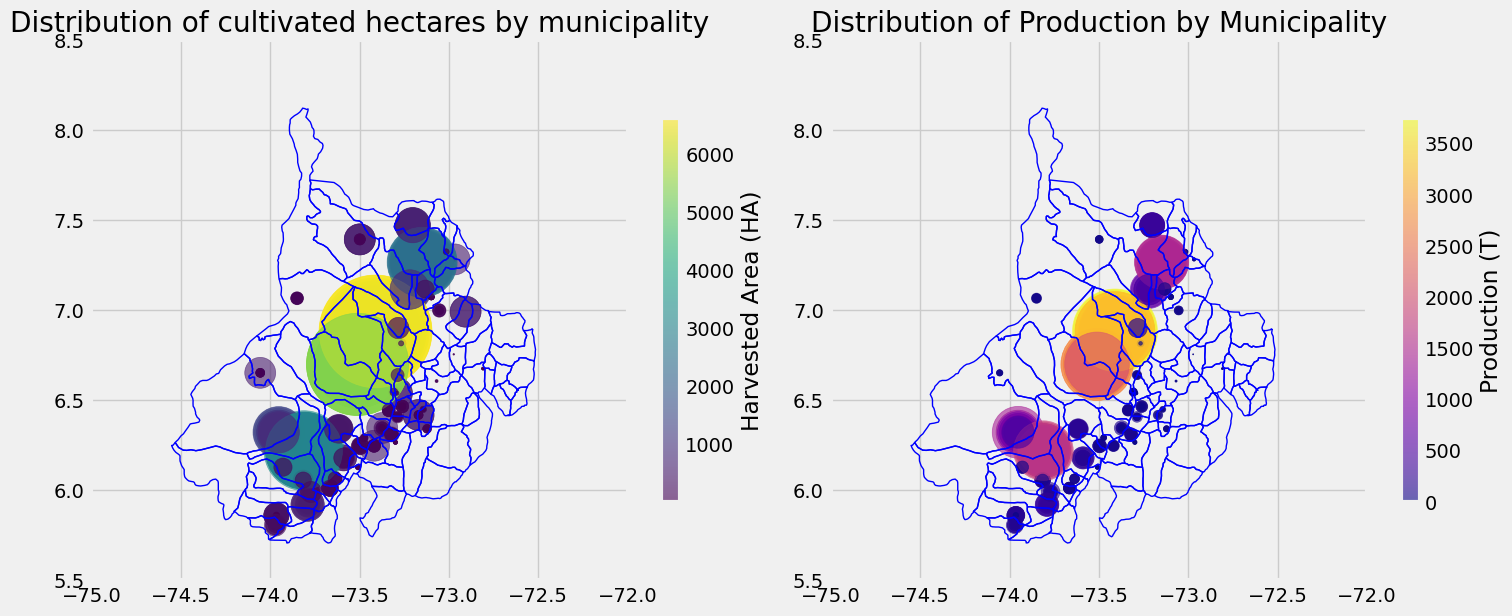

In [94]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo geoJSON
gdf = gpd.read_file('F://Proyecto_monografia//shapes.geojson')

# Crear una figura con subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Crear el primer mapa
scatter1 = axes[0].scatter(
    df_cacao_original['LONGITUD'], df_cacao_original['LATITUD'], 
    s=df_cacao_original['AREA COSECHADA (HA)']/2, 
    c=df_cacao_original['AREA COSECHADA (HA)']/2, 
    cmap='viridis', 
    alpha=0.6
)
gdf.boundary.plot(ax=axes[0], color='blue', linewidth=1)
axes[0].set_title('Distribution of cultivated hectares by municipality')

# Crear la barra de colores para el primer mapa
cbar1 = fig.colorbar(scatter1, ax=axes[0], orientation='vertical',shrink=0.4)
cbar1.set_label('Harvested Area (HA)')

# Crear el segundo mapa
scatter2 = axes[1].scatter(
    df_cacao_original['LONGITUD'], df_cacao_original['LATITUD'], 
    s=df_cacao_original['PRODUCCION (T)']/2,  # Ajustar el tamaño de los puntos
    c=df_cacao_original['PRODUCCION (T)']/2, 
    cmap='plasma', 
    alpha=0.6
)
gdf.boundary.plot(ax=axes[1], color='blue', linewidth=1)
axes[1].set_title('Distribution of Production by Municipality')

# Crear la barra de colores para el segundo mapa
cbar2 = fig.colorbar(scatter2, ax=axes[1], orientation='vertical',shrink=0.4)
cbar2.set_label('Production (T)')


# ajustar las etiquetas
for ax in axes:
    ax.tick_params(axis='both', which='major', pad=5)
    ax.set_xticks(ax.get_xticks(), minor=False)
    ax.set_yticks(ax.get_yticks(), minor=False)
    
# Ajustar el layout
plt.tight_layout()
plt.show()


## **Visualizacion de las precipitaciones**

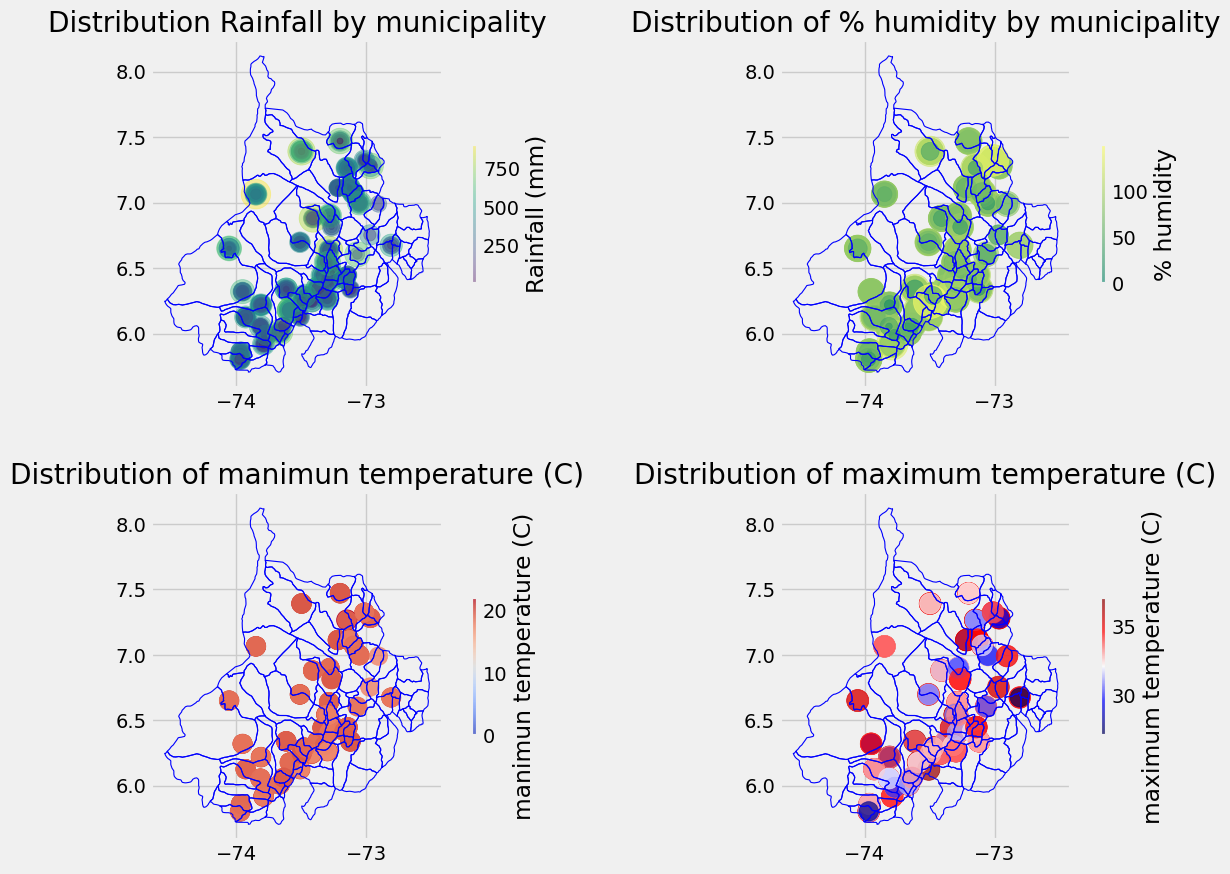

In [95]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo geoJSON
gdf = gpd.read_file('F://Proyecto_monografia//shapes.geojson')

# Crear una figura con subgráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# guardando en variables
(ax1, ax2), (ax3, ax4) = axes



# Crear el primer mapa -----------------------------------------
scatter1 = ax1.scatter(
    df_cacao_original['LONGITUD'], df_cacao_original['LATITUD'], 
    s=df_cacao_original['PRECIPITACIONES (MM)']/2, 
    c=df_cacao_original['PRECIPITACIONES (MM)'], 
    cmap='viridis', 
    alpha=0.4
)
gdf.boundary.plot(ax=ax1, color='blue', linewidth=0.8)
ax1.set_title('Distribution Rainfall by municipality')


# Crear la barra de colores para el primer mapa
cbar1 = fig.colorbar(scatter1, ax=ax1, orientation='vertical',shrink=0.4)
cbar1.set_label('Rainfall (mm)')

# Crear el segundo mapa -----------------------------------------
scatter2 = ax2.scatter(
    df_cacao_original['LONGITUD'], df_cacao_original['LATITUD'],
    s=df_cacao_original['HUMEDAD (%)']*4, 
    c=df_cacao_original['HUMEDAD (%)'], 
    cmap='summer', 
    alpha=0.6
)

gdf.boundary.plot(ax=ax2, color='blue', linewidth=0.8)
ax2.set_title('Distribution of % humidity by municipality')

# Crear la barra de colores para el segundo mapa
cbar2 = fig.colorbar(scatter2, ax=ax2, orientation='vertical',shrink=0.4)
cbar2.set_label('% humidity')

# Crear el tercer mapa -----------------------------------------
scatter3 = ax3.scatter(
    df_cacao_original['LONGITUD'], df_cacao_original['LATITUD'],
    s=df_cacao_original['TEMPERATURA MINIMA (C)']*10, 
    c=df_cacao_original['TEMPERATURA MINIMA (C)'], 
    cmap='coolwarm', 
    alpha=0.8
)

gdf.boundary.plot(ax=ax3, color='blue', linewidth=0.8)
ax3.set_title('Distribution of manimun temperature (C)')

# Crear la barra de colores para el tercer mapa
cbar3 = fig.colorbar(scatter3, ax=ax3, orientation='vertical',shrink=0.4)
cbar3.set_label('manimun temperature (C)')

# Crear el cuarto mapa -----------------------------------------
scatter4 = ax4.scatter(
    df_cacao_original['LONGITUD'], df_cacao_original['LATITUD'],
    s=df_cacao_original['TEMPERATURA MAXIMA (C)']*7, 
    c=df_cacao_original['TEMPERATURA MAXIMA (C)'], 
    cmap='seismic', 
    alpha=0.7
)

gdf.boundary.plot(ax=ax4, color='blue', linewidth=0.8)
ax4.set_title('Distribution of maximum temperature (C)')


# Crear la barra de colores para el tercer mapa
cbar4 = fig.colorbar(scatter4, ax=ax4, orientation='vertical',shrink=0.4)
cbar4.set_label('maximum temperature (C)')



# Ajustar los márgenes y el espacio entre los subgráficos
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.3)
plt.show()

## **Experimentar con combinaciones de atributos**

In [96]:
cacao['RENDIMIENTO (T/HA)'] = cacao['PRODUCCION (T)'] / cacao['AREA COSECHADA (HA)']  # calculamos la cantidad de producto obtenido por unidad de recurso utilizado

matriz_correlacion = cacao.select_dtypes(include=['float64','int64']).corr()

#visualizamos la correlacion con respecto a la produccion
matriz_correlacion['PRODUCCION (T)'].sort_values(ascending=False)


PRODUCCION (T)                      1.000000
AREA SEMBRADA (HA)                  0.986075
AREA COSECHADA (HA)                 0.985554
LATITUD                             0.152085
COD MUN                             0.038139
TEMPERATURA MINIMA (C)             -0.006773
PRECIPITACIONES (MM)               -0.008287
AÑO                                -0.010340
BRILLO SOLAR (Horas sol diarias)   -0.011422
HUMEDAD (%)                        -0.035045
RENDIMIENTO (T/HA)                 -0.061740
LONGITUD                           -0.080843
TEMPERATURA MAXIMA (C)             -0.106420
COD DEPART                               NaN
Name: PRODUCCION (T), dtype: float64

In [97]:
#from ydata_profiling import ProfileReport

#ProfileReport(cacao)

## **Descubriendo las distribuciones**

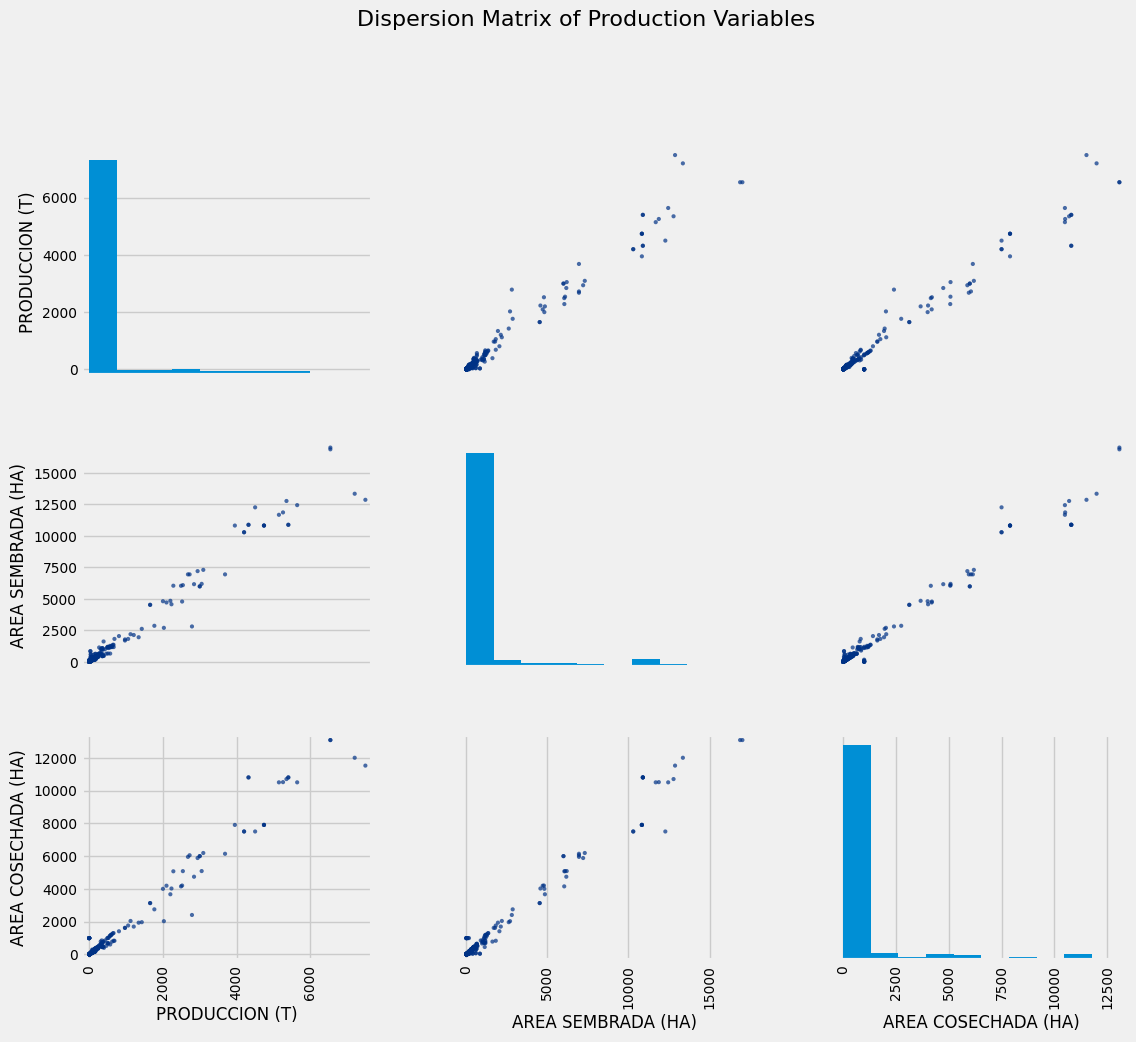

In [98]:
from pandas.plotting import scatter_matrix

atributos = ['PRODUCCION (T)', 'AREA SEMBRADA (HA)', 'AREA COSECHADA (HA)']

# Crear la matriz de dispersión
axes = scatter_matrix(cacao[atributos], figsize=(12, 10), alpha=0.7, c='#003285')

# Ajustar el espaciado entre los subgráficos
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Cambiar las etiquetas de los ejes y el tamaño de las etiquetas
for ax in axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)  # Ajusta el tamaño del título del eje x
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)  # Ajusta el tamaño del título del eje y

# Cambiar el tamaño de las etiquetas de los ticks
for ax in axes.flatten():
    ax.tick_params(axis='both', labelsize=10)  # Ajusta el tamaño de las etiquetas de los ticks

# Establecer el título de la figura
plt.suptitle('Dispersion Matrix of Production Variables', fontsize=16, y=1.02)  # y=1.02 para ajustar la posición

# Mostrar el gráfico
plt.show()

c:\Users\ajolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


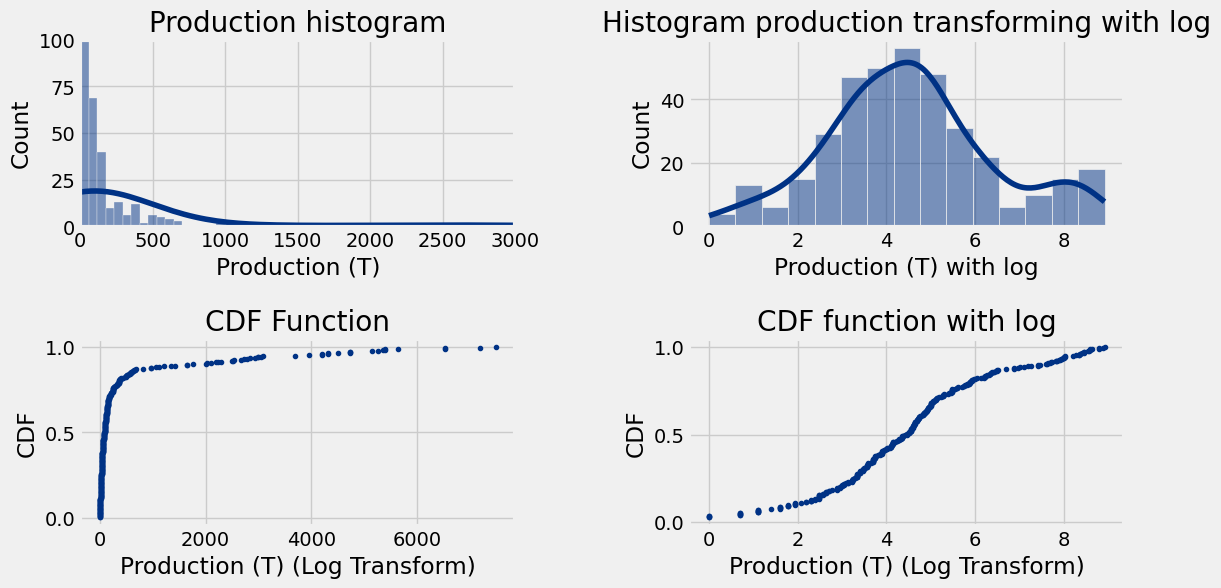

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Transformación logarítmica de los datos
tranform_log = np.log(cacao['PRODUCCION (T)'])

#funcion de densidad acumulativa
def cdf(data):
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, yvals


# Crear figuras y ejes
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
(ax1, ax2), (ax3,ax4) = axes

# -------------------  HISTOGRAMAS --------------------------------------
# Histograma con KDE para la columna 'PRODUCCION (T)'
sns.histplot(cacao['PRODUCCION (T)'], kde=True, ax=ax1, color= '#003285')
ax1.set_title('Production histogram',fontsize=20)
ax1.set_xlim(0, 3000)
ax1.set_ylim(0, 100) 


# Histograma con KDE para los datos transformados logarítmicamente
sns.histplot(tranform_log, kde=True, ax=ax2, color='#003285')
ax2.set_title('Histogram production transforming with log', fontsize=20)

# Etiquetas de los ejes
ax1.set_xlabel('Production (T)')
ax1.set_ylabel('Count')
ax2.set_xlabel('Production (T) with log')
ax2.set_ylabel('Count')

# -------------------- CDF --------------------------------------------------
x1, y1 = cdf(cacao['PRODUCCION (T)'])
x2, y2 = cdf(tranform_log)

# grafico 3 con cdf
ax3.plot(x1, y1, marker='.',linestyle='none', color='#003285')
ax3.set_xlabel('Production (T) (Log Transform)')
ax3.set_ylabel('CDF')
ax3.set_title('CDF Function')
ax3.grid(True)

# grafico 4 con cdf
ax4.plot(x2, y2, marker='.',linestyle='none', color='#003285')
ax4.set_xlabel('Production (T) (Log Transform)')
ax4.set_ylabel('CDF')
ax4.set_title('CDF function with log')
ax4.grid(True)

#mejorando espaciados
plt.subplots_adjust(wspace=0.4, hspace=0.6)
# Mostrar los gráficos
plt.show()




In [100]:
cacao = conjunto_entreno.drop('PRODUCCION (T)', axis=1) # quitamos los valores que deseamos predecir de nuestro df, quedando solo con los predictores
cacao_labels = conjunto_entreno['PRODUCCION (T)'].copy() #y el valor a predecir lo separamos en un nuevo dataframe df

cacao_prueba = conjunto_prueba.drop('PRODUCCION (T)', axis=1)
cacao_prueba_labels = conjunto_prueba['PRODUCCION (T)'].copy()

## **Preparacion de datos para los algoritmos**

In [101]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import OrdinalEncoder

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [102]:
# composicion para tranformar los datos buscando una distribucion en forma de campana
log_canalizaciones = make_pipeline(
                SimpleImputer(strategy='median'),
                FunctionTransformer(np.log, feature_names_out='one-to-one'),
                StandardScaler()
)

cat_canalizaciones = make_pipeline(
                     SimpleImputer(strategy='most_frequent'),
                     OneHotEncoder(handle_unknown='ignore')
)

#buscamos los vecinos mas cercanos para mejorar la latitud y la longitud
simil_cluster = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)

#creamos una canalizacion por defecto
defecto_canalizacion = make_pipeline(
                       SimpleImputer(strategy='median'),
                       StandardScaler()
)

preprocesado = ColumnTransformer([
               ('log', log_canalizaciones,['AREA COSECHADA (HA)','AREA SEMBRADA (HA)']),
               ('geo', simil_cluster,['LATITUD','LONGITUD']),
               ('cat', cat_canalizaciones, make_column_selector(dtype_include=object)), 
               ('num', defecto_canalizacion, ['PRECIPITACIONES (MM)','HUMEDAD (%)','TEMPERATURA MAXIMA (C)','TEMPERATURA MINIMA (C)','BRILLO SOLAR (Horas sol diarias)'])
                ], remainder=defecto_canalizacion               
)


In [103]:
cacao_preparado = preprocesado.fit_transform(cacao)

## **Entrenar un modelo de regresion lineal**


In [104]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocesado, 
                        LinearRegression())

lin_reg.fit(cacao, cacao_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000224996FF610>),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['PRECIPITACIONES (MM)',
                                                   'HUMEDAD (%)',
                                                   'TEMPERATURA MAXIMA (C)',
                                                   'TEMPERATURA MINIMA (C)',
                                                   'BRILLO SOLAR (Horas sol '
                                                   'diarias)'])])),
                ('linearregression', LinearRegression())])

In [105]:
from sklearn.metrics import mean_squared_error

# ------------ PREDICCION ------------------
cacao_predic_train = lin_reg.predict(cacao)
cacao_predic_test = lin_reg.predict(cacao_prueba)

# ------------ VALIDACION ---------------
error_cuadratico_entrenamiento = mean_squared_error(cacao_labels, cacao_predic_train, squared=False)
error_cuadratico_prueba = mean_squared_error(cacao_prueba_labels, cacao_predic_test, squared=False)


print('error cuadratico medio conjunto entrenamiento: ',error_cuadratico_entrenamiento)
print('error cuadratico medio conjunto prueba: ',error_cuadratico_prueba)

print('Puntaje del modelo en el entrenamiento: ',lin_reg.score(cacao, cacao_labels) * 100)
print('Puntaje del modelo en la prueba: ',lin_reg.score(cacao_prueba, cacao_prueba_labels) * 100)

error cuadratico medio conjunto entrenamiento:  198.80295093838322
error cuadratico medio conjunto prueba:  271.09362421947134
Puntaje del modelo en el entrenamiento:  97.5006662392574
Puntaje del modelo en la prueba:  95.51431034466835


c:\Users\ajolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ajolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### **Graficando el modelo de regresion Lineal**

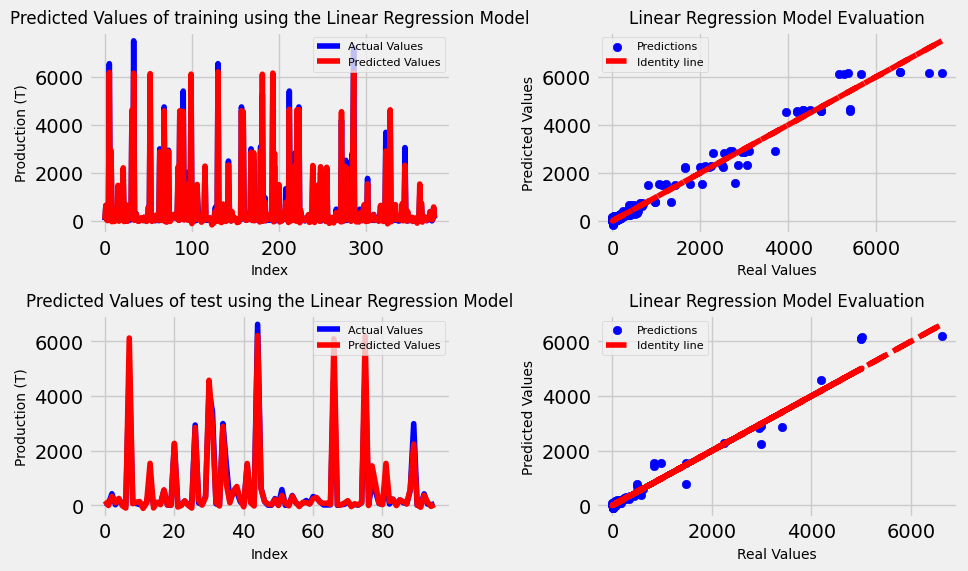

In [106]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows= 2, ncols=2, figsize=(10, 6))

# Creando las variables
ax1= ax[0,0]
ax2= ax[0,1]
ax3= ax[1,0]
ax4= ax[1,1]

# Graficando el primer gráfico ------------------------------------
# Gráfica de dispersión de los valores reales de los datos de entrenamiento
ax1.plot(range(len(cacao_labels)), cacao_labels, color='blue', label='Actual Values')
# Gráfica de dispersión de los valores predichos
ax1.plot(range(len(cacao_predic_train)), cacao_predic_train, color='red', label='Predicted Values')

# Graficando el segundo gráfico ------------------------------------
ax2.scatter(cacao_labels, cacao_predic_train, color='blue', label='Predictions')
ax2.plot(cacao_labels, cacao_labels, color='red', label='Identity line', linestyle='--')

# Graficando el tercer gráfico -------------------------------------
ax3.plot(range(len(cacao_prueba_labels)), cacao_prueba_labels, color='blue', label='Actual Values')
ax3.plot(range(len(cacao_predic_test)), cacao_predic_test, color='red', label='Predicted Values')

# Graficando el cuarto gráfico ------------------------------------
ax4.scatter(cacao_prueba_labels, cacao_predic_test, color='blue', label='Predictions')
ax4.plot(cacao_prueba_labels, cacao_prueba_labels, color='red', label='Identity line', linestyle='--')

# Configurando los títulos con tamaño de letra
ax1.set_title('Predicted Values of training using the Linear Regression Model', fontsize=12)
ax2.set_title('Linear Regression Model Evaluation', fontsize=12)
ax3.set_title('Predicted Values of test using the Linear Regression Model', fontsize=12)
ax4.set_title('Linear Regression Model Evaluation', fontsize=12)

# Configurando las etiquetas con tamaño de letra
ax1.set_xlabel('Index', fontsize=10)
ax1.set_ylabel('Production (T)', fontsize=10)
ax2.set_xlabel('Real Values', fontsize=10)
ax2.set_ylabel('Predicted Values', fontsize=10)
ax3.set_xlabel('Index', fontsize=10)
ax3.set_ylabel('Production (T)', fontsize=10)
ax4.set_xlabel('Real Values', fontsize=10)
ax4.set_ylabel('Predicted Values', fontsize=10)

# Configurando las leyendas
ax1.legend(loc='upper right', fontsize=8)
ax2.legend(loc='upper left', fontsize=8)
ax3.legend(loc='upper right', fontsize=8)
ax4.legend(loc='upper left', fontsize=8)


plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


## **Entrenando el modelo de arboles de decisiones**

In [107]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocesado, DecisionTreeRegressor(random_state=42))
tree_reg.fit(cacao, cacao_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000224996FF610>),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['PRECIPITACIONES (MM)',
                                                   'HUMEDAD (%)',
                                                   'TEMPERATURA MAXIMA (C)',
                                                   'TEMPERATURA MINIMA (C)',
                                                   'BRILLO SOLAR (Horas sol '
                                                   'diarias)'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

### **Evaluando el modelo de arboles de desicion**

In [108]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# ------------ PREDICCION ------------------
cacao_predic_train = tree_reg.predict(cacao)
cacao_predic_test = tree_reg.predict(cacao_prueba)

# ------------ VALIDACION ---------------
error_cuadratico_entrenamiento = mean_squared_error(cacao_labels, cacao_predic_train, squared=False)
error_cuadratico_prueba = mean_squared_error(cacao_prueba_labels, cacao_predic_test, squared=False)

#Validacion cruzada
tree_rmses = -cross_val_score(tree_reg, cacao, cacao_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

print('error cuadratico medio conjunto entrenamiento: ',error_cuadratico_entrenamiento)
print('error cuadratico medio conjunto prueba: ',error_cuadratico_prueba)

print('Puntaje del modelo en el entrenamiento: ',tree_reg.score(cacao, cacao_labels) * 100)
print('Puntaje del modelo en la prueba: ',tree_reg.score(cacao_prueba, cacao_prueba_labels) * 100)

print('Validacion cruzada en el entrenamiento: ', tree_rmses.mean())

c:\Users\ajolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ajolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


error cuadratico medio conjunto entrenamiento:  0.0
error cuadratico medio conjunto prueba:  142.87906453827773
Puntaje del modelo en el entrenamiento:  100.0
Puntaje del modelo en la prueba:  98.75397196918084
Validacion cruzada en el entrenamiento:  192.88647698256125


## **Graficando la prediccion en el arbol de desicion**

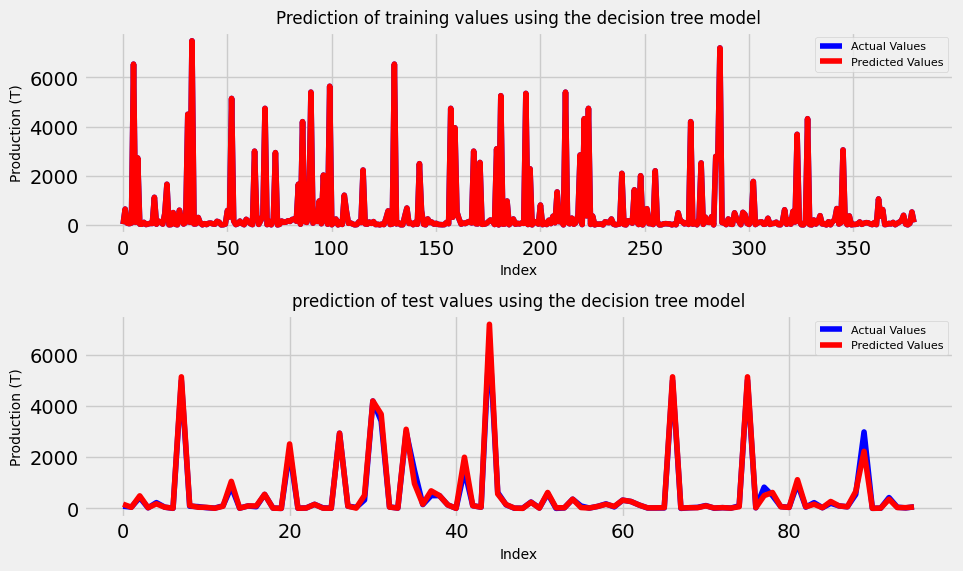

In [109]:
fig, ax = plt.subplots(nrows= 2, ncols=1, figsize=(10, 6))

#creando las variables
ax1= ax[0]
ax2= ax[1]


#graficando el primer grafico ------------------------------------

# Gráfica de dispersión de los valores reales de los datos de entrenamiento
ax1.plot(range(len(cacao_labels)), cacao_labels, color='blue', label='Actual Values')
# Gráfica de dispersión de los valores predichos
ax1.plot(range(len(cacao_predic_train)), cacao_predic_train, color='red', label='Predicted Values')

#graficando el segundo grafico ------------------------------------

# Gráfica de dispersión de los valores reales de los datos de prueba
ax2.plot(range(len(cacao_prueba_labels)), cacao_prueba_labels, color='blue', label='Actual Values')
# Gráfica de dispersión de los valores predichos
ax2.plot(range(len(cacao_predic_test)), cacao_predic_test, color='red', label='Predicted Values')


#configurando los titulos
ax1.set_title('Prediction of training values using the decision tree model', fontsize=12)
ax2.set_title('prediction of test values using the decision tree model',fontsize=12)

#configarando las etiquetas
ax1.set_xlabel('Index',fontsize=10)
ax1.set_ylabel('Production (T)',fontsize=10)
ax2.set_xlabel('Index',fontsize=10)
ax2.set_ylabel('Production (T)',fontsize=10)

ax1.legend(fontsize=8)
ax2.legend(fontsize=8)

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()



## **Visualizando el arbol de desicion**

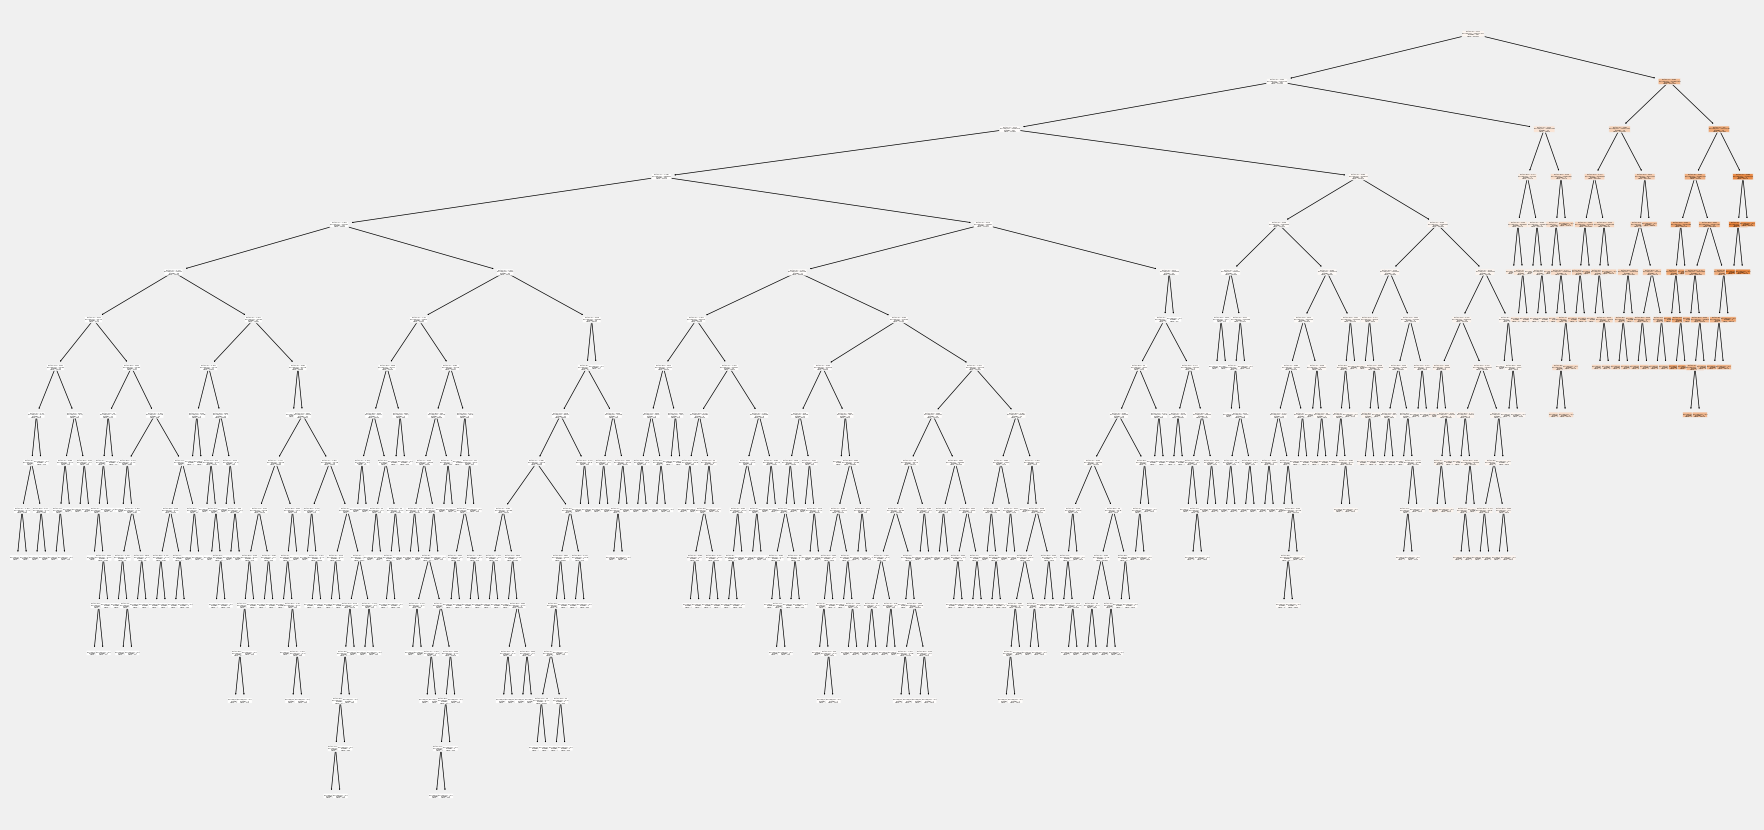

In [110]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocesado, DecisionTreeRegressor(random_state=42))
tree_reg.fit(cacao, cacao_labels)

decision_tree = tree_reg.named_steps['decisiontreeregressor']


feature_names = [f'Feature {i}' for i in range(decision_tree.n_features_in_)]

plt.figure(figsize=(20,10))  # Tamaño de la figura
plot_tree(decision_tree, filled=True, feature_names=feature_names, rounded=True)
plt.show()



In [111]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Extrae el modelo del pipeline
decision_tree = tree_reg.named_steps['decisiontreeregressor']

feature_names = [f'Feature {i}' for i in range(decision_tree.n_features_in_)]

# Crea la visualización
#plt.figure(figsize=(20,10))
#plot_tree(decision_tree, filled=True, feature_names=feature_names, rounded=True)


# Guarda la visualización en un archivo PDF
#plt.savefig('decision_tree.pdf', format='pdf')

plt.close()


### **Evaluando el modelo de bosques aleatorios**

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

forest_reg = make_pipeline(preprocesado,
                           RandomForestRegressor(random_state=42))

forest_reg.fit(cacao, cacao_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000224996FF610>),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['PRECIPITACIONES (MM)',
                                                   'HUMEDAD (%)',
                                                   'TEMPERATURA MAXIMA (C)',
                                                   'TEMPERATURA MINIMA (C)',
                                                   'BRILLO SOLAR (Horas sol '
                                                   'diarias)'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [113]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# ------------ PREDICCION ------------------
cacao_predic_train = forest_reg.predict(cacao)
cacao_predic_test = forest_reg.predict(cacao_prueba)

# ------------ VALIDACION ---------------
error_cuadratico_entrenamiento = mean_squared_error(cacao_labels, cacao_predic_train, squared=False)
error_cuadratico_prueba = mean_squared_error(cacao_prueba_labels, cacao_predic_test, squared=False)

#Validacion cruzada
tree_rmses = -cross_val_score(forest_reg, cacao, cacao_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

print('error cuadratico medio conjunto entrenamiento: ',error_cuadratico_entrenamiento)
print('error cuadratico medio conjunto prueba: ',error_cuadratico_prueba)

print('Puntaje del modelo en el entrenamiento: ',forest_reg.score(cacao, cacao_labels) * 100)
print('Puntaje del modelo en la prueba: ',forest_reg.score(cacao_prueba, cacao_prueba_labels) * 100)

print('Validacion cruzada en el entrenamiento: ', tree_rmses.mean())

c:\Users\ajolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ajolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


error cuadratico medio conjunto entrenamiento:  66.64446561497259
error cuadratico medio conjunto prueba:  130.4847549724041
Puntaje del modelo en el entrenamiento:  99.71912907639835
Puntaje del modelo en la prueba:  98.96077361422545
Validacion cruzada en el entrenamiento:  154.1702251416574


## **Graficando la prediccion en el arbol de desicion**

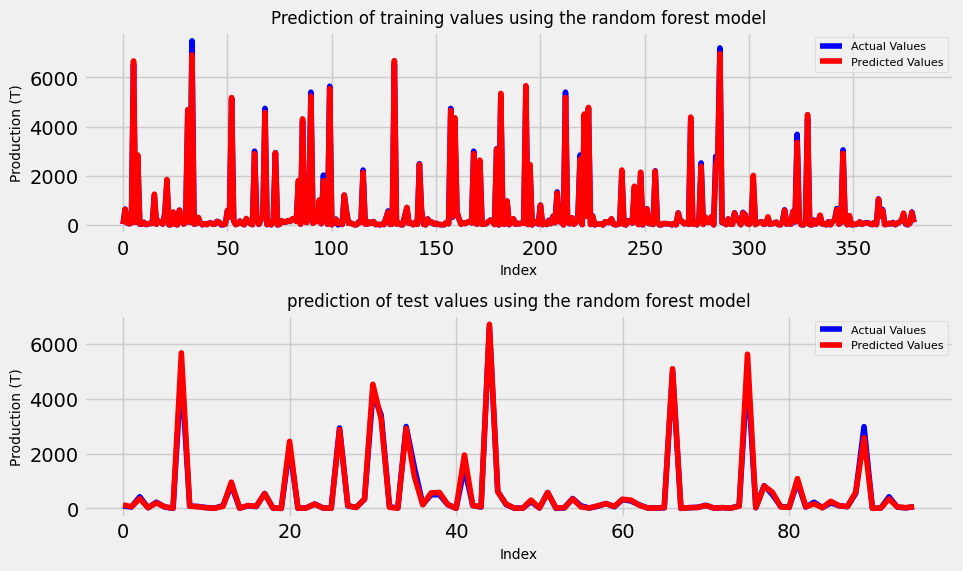

In [114]:
fig, ax = plt.subplots(nrows= 2, ncols=1, figsize=(10, 6))

#creando las variables
ax1= ax[0]
ax2= ax[1]


#graficando el primer grafico ------------------------------------

# Gráfica de dispersión de los valores reales de los datos de entrenamiento
ax1.plot(range(len(cacao_labels)), cacao_labels, color='blue', label='Actual Values')
# Gráfica de dispersión de los valores predichos
ax1.plot(range(len(cacao_predic_train)), cacao_predic_train, color='red', label='Predicted Values')

#graficando el segundo grafico ------------------------------------

# Gráfica de dispersión de los valores reales de los datos de prueba
ax2.plot(range(len(cacao_prueba_labels)), cacao_prueba_labels, color='blue', label='Actual Values')
# Gráfica de dispersión de los valores predichos
ax2.plot(range(len(cacao_predic_test)), cacao_predic_test, color='red', label='Predicted Values')


#configurando los titulos
ax1.set_title('Prediction of training values using the random forest model', fontsize=12)
ax2.set_title('prediction of test values using the random forest model',fontsize=12)

#configarando las etiquetas
ax1.set_xlabel('Index',fontsize=10)
ax1.set_ylabel('Production (T)',fontsize=10)
ax2.set_xlabel('Index',fontsize=10)
ax2.set_ylabel('Production (T)',fontsize=10)

ax1.legend(fontsize=8)
ax2.legend(fontsize=8)

plt.subplots_adjust(hspace=0.4, wspace=0.4);


##  **Mejorando los modelos**



In [115]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
 ("preprocesado", preprocesado),
 ("random_forest", RandomForestRegressor(random_state=42)),
])

param_grid = [
 {'preprocesado__geo__n_clusters': [5, 8, 10],
 'random_forest__max_features': [4, 6, 8]},
 {'preprocesado__geo__n_clusters': [10, 15],
 'random_forest__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
 scoring='neg_root_mean_squared_error')

grid_search.fit(cacao, cacao_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('log',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out='one-to-...
                                                                          'MAXIMA '
                                                                          '(C)',
                                                                          'TEMPERATURA '
                                                                          'MINIMA '
                                                                          '(C)',
                                                                          'BRILLO '
                                                                          'SOLAR '
                                                                          '(Horas '
                                                                          'sol '
                                                                          'diarias)'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocesado__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocesado__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [116]:
grid_search.best_params_

{'preprocesado__geo__n_clusters': 15, 'random_forest__max_features': 10}

In [117]:
# mirando los mejores parametros 

cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocesado__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,0.237572,0.001399,0.019842,0.000396,15,10,"{'preprocesado__geo__n_clusters': 15, 'random_...",-191.826224,-177.247343,-197.397005,-188.823524,8.495661,1
11,0.234948,0.002862,0.031000,0.015330,10,10,"{'preprocesado__geo__n_clusters': 10, 'random_...",-208.360316,-172.439467,-188.526604,-189.775462,14.691190,2
13,0.232230,0.003670,0.020327,0.001391,15,8,"{'preprocesado__geo__n_clusters': 15, 'random_...",-217.055009,-174.732122,-191.644689,-194.477273,17.393952,3
5,0.225417,0.005698,0.098322,0.109896,8,8,"{'preprocesado__geo__n_clusters': 8, 'random_f...",-227.456334,-152.609977,-204.047346,-194.704552,31.261906,4
8,0.225408,0.003898,0.019125,0.000015,10,8,"{'preprocesado__geo__n_clusters': 10, 'random_...",-228.630099,-163.813489,-195.134892,-195.859493,26.466230,5


In [118]:
# haciendolo de forma aleatoria
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocesado__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
   full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
   scoring= 'neg_root_mean_squared_error', random_state=42) 

rnd_search.fit(cacao, cacao_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocesado',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='o...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocesado__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022496A27690>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000224973E0DD0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

## **Analizando los mejores modelos y sus errores**

In [119]:
modelo_final = rnd_search.best_estimator_
feature_importances = modelo_final['random_forest'].feature_importances_
feature_importances.round(2)

array([0.26, 0.21, 0.01, 0.  , 0.01, 0.  , 0.03, 0.  , 0.01, 0.01, 0.01,
       0.05, 0.  , 0.  , 0.02, 0.  , 0.01, 0.1 , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.02,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ])

In [141]:
import_relati=sorted(zip(feature_importances,
            modelo_final["preprocesado"].get_feature_names_out()),
            reverse=True)

df_import_relati = np.array(import_relati)

prueba = pd.DataFrame(df_import_relati, columns=['Relative importance', 'Variable'])

relative_importance =prueba.sort_values(by='Relative importance', ascending=False)

#relative_importance.to_excel('importancia_relativa_RF.xlsx',index=False)



## **Evaluando el sistema en el conjunto de prueba**

In [121]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# ------------ PREDICCION ------------------
cacao_predic_train = modelo_final.predict(cacao)
cacao_predic_test = modelo_final.predict(cacao_prueba)

# ------------ VALIDACION ---------------
error_cuadratico_entrenamiento = mean_squared_error(cacao_labels, cacao_predic_train, squared=False)
error_cuadratico_prueba = mean_squared_error(cacao_prueba_labels, cacao_predic_test, squared=False)

#Validacion cruzada
tree_rmses = -cross_val_score(modelo_final, cacao, cacao_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

print('error cuadratico medio conjunto entrenamiento: ',error_cuadratico_entrenamiento)
print('error cuadratico medio conjunto prueba: ',error_cuadratico_prueba)

print('Puntaje del modelo en el entrenamiento: ',modelo_final.score(cacao, cacao_labels) * 100)
print('Puntaje del modelo en la prueba: ',modelo_final.score(cacao_prueba, cacao_prueba_labels) * 100)

print('Validacion cruzada en el entrenamiento: ', tree_rmses.mean())

c:\Users\ajolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ajolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


error cuadratico medio conjunto entrenamiento:  65.45181284329475
error cuadratico medio conjunto prueba:  168.76324037563197
Puntaje del modelo en el entrenamiento:  99.7290919175676
Puntaje del modelo en la prueba:  98.26161355377899
Validacion cruzada en el entrenamiento:  163.39481930147946


## **Graficando el modelo final**

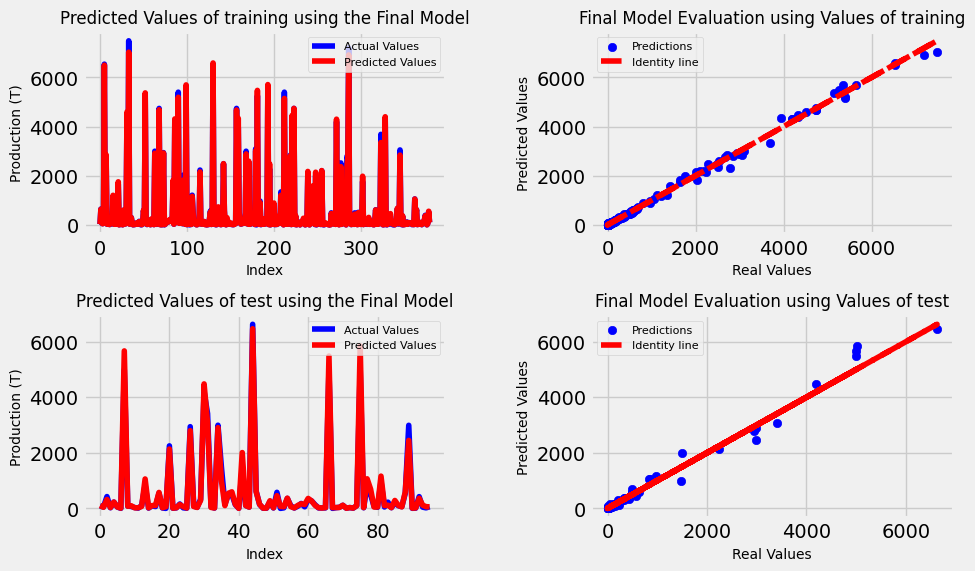

In [125]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows= 2, ncols=2, figsize=(10, 6))

# Creando las variables
ax1= ax[0,0]
ax2= ax[0,1]
ax3= ax[1,0]
ax4= ax[1,1]

# Graficando el primer gráfico ------------------------------------
# Gráfica de dispersión de los valores reales de los datos de entrenamiento
ax1.plot(range(len(cacao_labels)), cacao_labels, color='blue', label='Actual Values')
# Gráfica de dispersión de los valores predichos
ax1.plot(range(len(cacao_predic_train)), cacao_predic_train, color='red', label='Predicted Values')

# Graficando el segundo gráfico ------------------------------------
ax2.scatter(cacao_labels, cacao_predic_train, color='blue', label='Predictions')
ax2.plot(cacao_labels, cacao_labels, color='red', label='Identity line', linestyle='--')

# Graficando el tercer gráfico -------------------------------------
ax3.plot(range(len(cacao_prueba_labels)), cacao_prueba_labels, color='blue', label='Actual Values')
ax3.plot(range(len(cacao_predic_test)), cacao_predic_test, color='red', label='Predicted Values')

# Graficando el cuarto gráfico ------------------------------------
ax4.scatter(cacao_prueba_labels, cacao_predic_test, color='blue', label='Predictions')
ax4.plot(cacao_prueba_labels, cacao_prueba_labels, color='red', label='Identity line', linestyle='--')

# Configurando los títulos con tamaño de letra
ax1.set_title('Predicted Values of training using the Final Model', fontsize=12)
ax2.set_title('Final Model Evaluation using Values of training', fontsize=12)
ax3.set_title('Predicted Values of test using the Final Model', fontsize=12)
ax4.set_title('Final Model Evaluation using Values of test', fontsize=12)

# Configurando las etiquetas con tamaño de letra
ax1.set_xlabel('Index', fontsize=10)
ax1.set_ylabel('Production (T)', fontsize=10)
ax2.set_xlabel('Real Values', fontsize=10)
ax2.set_ylabel('Predicted Values', fontsize=10)
ax3.set_xlabel('Index', fontsize=10)
ax3.set_ylabel('Production (T)', fontsize=10)
ax4.set_xlabel('Real Values', fontsize=10)
ax4.set_ylabel('Predicted Values', fontsize=10)

# Configurando las leyendas
ax1.legend(loc='upper right', fontsize=8)
ax2.legend(loc='upper left', fontsize=8)
ax3.legend(loc='upper right', fontsize=8)
ax4.legend(loc='upper left', fontsize=8)


plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

### **Intervalo de confianza**



In [126]:
from scipy import stats
confianza = 0.95
error_cuadra = (cacao_predic_test  - cacao_prueba_labels) ** 2
np.sqrt(stats.t.interval(confianza, len(error_cuadra) - 1,
                         loc=error_cuadra.mean(),
                         scale=stats.sem(error_cuadra)))

array([ 92.99378378, 219.80495623])